<h1>Project 3: Swan Teleco</h1>
<h3>Customer Retention Marketing</h2>

Import Libraries

In [413]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
import scipy.stats as stats
from scipy.stats import zscore
from time import time
from tqdm import tqdm
import joblib
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


sns.set_style("whitegrid")




Functions for Model Evaluation

In [414]:
def apr(y_pred, y_real):


    accuracy = round(metrics.accuracy_score(y_real, y_pred),2)
    precision = round(metrics.precision_score(y_real, y_pred,pos_label='1'),2)
    recall = round(metrics.recall_score(y_real, y_pred,pos_label='1'),2)
    f1 = round(metrics.f1_score(y_real, y_pred,pos_label='1'),2)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##

def produce_confusion(positive_label, negative_label,y_test,y_pred):
    
   
    #Build the CM
    plt.figure(figsize=(7,5))

    cm = metrics.confusion_matrix(y_test, y_pred) 
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
    ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])

    plt.show()


### Import Data

In [415]:
file_name = "data/cleaned_data.csv"
df = pd.read_csv(file_name)
df.shape

(7032, 22)

In [416]:
df.head()

,CustomerID,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label,Churn Value
0,3668-QPYBK,1,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,1
1,9237-HQITU,1,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,1
2,9305-CDSKC,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,Yes,1
3,7892-POOKP,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,Yes,1
4,0280-XJGEX,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,Yes,1


In [417]:
# cols_to_remove =  ['Count','Churn Label','Lat Long','Country','State','City']

# df.drop(columns = cols_to_remove, inplace = True)

# # remove rows with whitespaces as values
# df = df.drop(df[df['Total Charges'] == ' '].index)
# df = df.drop(df[df['Monthly Charges'] == ' '].index)
# df.shape

In [418]:
df.isnull().mean().round(4) * 100

CustomerID           0.0
Count                0.0
Gender               0.0
Senior Citizen       0.0
Partner              0.0
Dependents           0.0
Tenure Months        0.0
Phone Service        0.0
Multiple Lines       0.0
Internet Service     0.0
Online Security      0.0
Online Backup        0.0
Device Protection    0.0
Tech Support         0.0
Streaming TV         0.0
Streaming Movies     0.0
Contract             0.0
Paperless Billing    0.0
Payment Method       0.0
Monthly Charges      0.0
Churn Label          0.0
Churn Value          0.0
dtype: float64

In [419]:
df[df['Churn Value'] == 0].shape

(5163, 22)

In [420]:
# Select only the continuous features from the dataset
cont_features = df.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = df.select_dtypes(include=['object']).columns.to_list()


In [421]:
cont_features

['Count', 'Tenure Months', 'Monthly Charges', 'Churn Value']

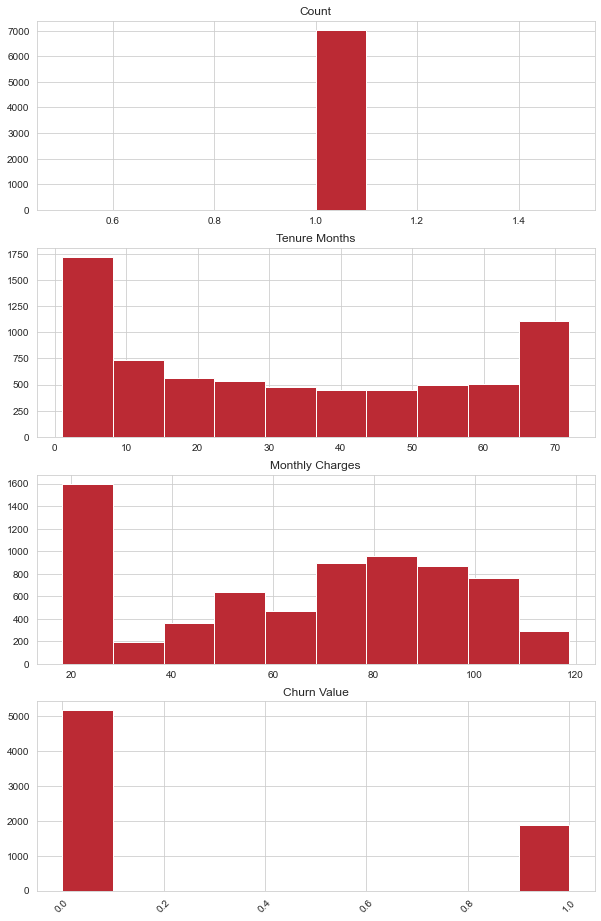

In [422]:
# Get the number of columns in the dataset

cont_df=df[cont_features]

num_columns = cont_df.shape[1]

# Create a figure with a subplot for each column
fig, axes = plt.subplots(num_columns, figsize=(10, num_columns*4))
# Rotate the x-axis labels at an angle
plt.xticks(rotation=45)
# Plot a histogram for each column
for i in range(num_columns):
    column = cont_df.columns[i]
    axes[i].hist(cont_df[column])
    axes[i].set_title(column)
    #axes[i].set_xticks(rotation=45)

plt.show()

In [423]:
df.describe()

,Count,Tenure Months,Monthly Charges,Churn Value
count,7032.0,7032.000000,7032.000000,7032.000000
mean,1.0,32.421786,64.798208,0.265785
std,0.0,24.545260,30.085974,0.441782
min,1.0,1.000000,18.250000,0.000000
25%,1.0,9.000000,35.587500,0.000000
50%,1.0,29.000000,70.350000,0.000000
75%,1.0,55.000000,89.862500,1.000000
max,1.0,72.000000,118.750000,1.000000


# Data Preparation

<li>In this part we split unchurned rows into train and test. This test data will be <i>X_test</i></li>
<li>Then we combine the churned data rows with unchurned train rows to form <i>X_train</i></li>

In [424]:
# split as churned and unchurned datadrames 

churned_df = df.loc[df['Churn Value'] == 1]
unchurned_df = df.loc[df['Churn Value'] == 0]

print(churned_df.shape)
print(unchurned_df.shape)

(1869, 22)
(5163, 22)


In [425]:
df['Churn Value'].value_counts()

0    5163
1    1869
Name: Churn Value, dtype: int64

In [426]:
def feature_engineer(df):


    cols_to_convert = [feature for feature in cont_features if len(df[feature].unique())<4]
    # Convert the columns to string type
    df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x.astype(str))

    # Label encode the columns
    df[cat_features] = df[cat_features].apply(LabelEncoder().fit_transform)

    # Convert the columns to string type
    df[cat_features+cols_to_convert] = df[cat_features+cols_to_convert].apply(lambda x: x.astype(str))

    return df

df_new=feature_engineer(df)
df_new.head()

,CustomerID,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label,Churn Value
0,2558,1,1,0,0,0,2,1,0,0,...,0,0,0,0,0,1,3,53.85,1,1
1,6500,1,0,0,0,1,2,1,0,1,...,0,0,0,0,0,1,2,70.70,1,1
2,6540,1,0,0,0,1,8,1,2,1,...,2,0,2,2,0,1,2,99.65,1,1
3,5593,1,0,0,1,1,28,1,2,1,...,2,2,2,2,0,1,2,104.80,1,1
4,174,1,1,0,0,1,49,1,2,1,...,2,0,2,2,0,1,0,103.70,1,1


### Correlation

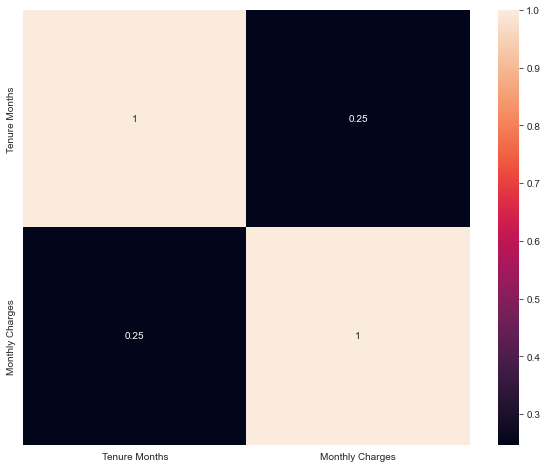

In [429]:
def plot_corr(df):
    plt.figure(figsize=(10, 8))

    # Set the color palette
    sns.set_palette(sns.color_palette("RdBu", n_colors=7))

    sns.heatmap(df.corr(),annot=True)
    plt.show()

plot_corr(df_new)

In [430]:
def undersample(df):

    positive_df = df[df['Churn Value']=='1']
    negative_df = df[df['Churn Value']!='1']
    negative_df=negative_df.sample(n=int((positive_df.shape[0])*1.4))

    df_new=pd.concat([positive_df,negative_df],axis=0)

    features=df_new.columns.to_list()
    features.remove('Churn Value')

    X=df_new[features]
    y=df_new['Churn Value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

    return X_train, X_test, y_train, y_test

    
X_train, X_test, y_train, y_test = undersample(df)
#X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 20)
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape) 

X_train shape: (3139, 21)
y_train shape: (3139,)
X_test shape: (1346, 21)
y_test shape: (1346,)


###  Feature Engineering

In [431]:
X_train.columns

Index(['CustomerID', 'Count', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Churn Label'],
      dtype='object')

In [432]:
# X_train = feature_eng(X_train)
# X_test = feature_eng(X_test)


len(list(X_train.columns))

21

# Modelling

In [433]:
def get_best_params(X,y):
   """
   Gets the best params
   i/p:X,y
   o/p:params
   """
   rf = RandomForestClassifier(n_estimators=50)
   # Use StratifiedKFold with 5 folds
   skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)


   rf_params = {
   'n_estimators': [150,200,250],
   'max_depth': [ x for x in range(1,len(X.columns))],
   }

   gs = GridSearchCV(rf, param_grid=rf_params, cv=skf,error_score="raise")

   gs.fit(X, y)


   print(gs.best_score_)

   params = gs.best_params_
      
   return params

In [434]:
X_train.head(2)

,CustomerID,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label
6500,2113,1,0,0,0,0,32,1,0,2,...,1,1,1,1,1,0,0,0,19.9,0
1294,2559,1,1,0,0,0,5,0,1,0,...,2,0,0,2,2,0,1,3,51.0,1


In [435]:
all_cols = set(X_train.columns)

cols_to_remove = {'CustomerID',
                    'Count'
                    'Zip Code',
                    'Lat Long',
                    'Total Charges',
                    'Internet Service_Fiber optic',
                    'Internet Service_No',
                    'Multiple Lines_No phone service',
                    'Latitude',
                    'Longitude',
                    'Churn Label',
                    'Churn Reason'
                    }
cols_filtered = list(all_cols-cols_to_remove)


In [436]:
X_train[cols_filtered].dtypes

Contract              object
Online Security       object
Gender                object
Device Protection     object
Streaming TV          object
Count                 object
Phone Service         object
Paperless Billing     object
Streaming Movies      object
Online Backup         object
Multiple Lines        object
Payment Method        object
Partner               object
Dependents            object
Tenure Months          int64
Monthly Charges      float64
Internet Service      object
Senior Citizen        object
Tech Support          object
dtype: object

In [437]:
best_params = get_best_params(X_train[cols_filtered],y_train)

rf_base = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
rf_base.fit(X_train[cols_filtered],y_train)


0.7782723310882881


RandomForestClassifier(max_depth=8, n_estimators=250)

In [438]:
# Get the feature importances
importances = rf_base.feature_importances_

feature_names = cols_filtered

# Print the importances

feature_importances = dict(zip(feature_names, importances))
feature_importances


{'Contract': 0.1965511074080554,
 'Online Security': 0.10160108438676417,
 'Gender': 0.012881171192262387,
 'Device Protection': 0.024111756768836465,
 'Streaming TV': 0.01254936574704834,
 'Count': 0.0,
 'Phone Service': 0.006355356263052204,
 'Paperless Billing': 0.02283950981853628,
 'Streaming Movies': 0.013199215703267975,
 'Online Backup': 0.03340778603116336,
 'Multiple Lines': 0.013677023102024885,
 'Payment Method': 0.035416099436128855,
 'Partner': 0.015693804919164833,
 'Dependents': 0.07251698092338012,
 'Tenure Months': 0.18925520161133969,
 'Monthly Charges': 0.12157176527469214,
 'Internet Service': 0.04736530870243243,
 'Senior Citizen': 0.012021668412621781,
 'Tech Support': 0.06898579429922846}

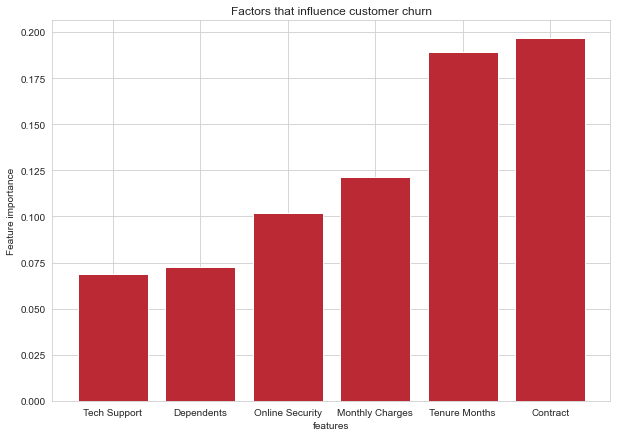

In [439]:
# Zip the lists and sort by the values in list1
sorted_filtered_lists = [tup for tup in sorted(zip(importances, feature_names), key=lambda x: x[0]) if tup[0] >= 0.06]
# Unzip the sorted lists
importances, feature_names = zip(*sorted_filtered_lists)

importances, feature_names = list(importances), list(feature_names)

# Plot the importances

# Set figure size

plt.figure(figsize=(10, 7))
plt.title('Factors that influence customer churn')
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(feature_names)), feature_names)
plt.xlabel("features")
plt.ylabel("Feature importance")

plt.show()


In [440]:
best_params

{'max_depth': 8, 'n_estimators': 250}

In [441]:
feature_names

['Tech Support',
 'Dependents',
 'Online Security',
 'Monthly Charges',
 'Tenure Months',
 'Contract']

In [442]:
imp_features = feature_names

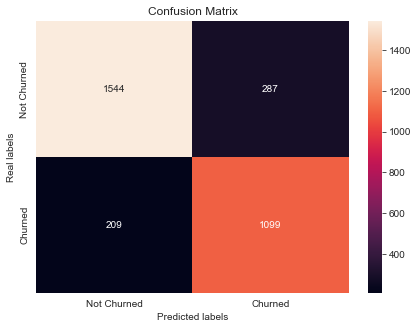

Score: 0.8419878942338325
Accuracy:0.84
Precision:0.79
Recall:0.84
F1:0.82


In [443]:
best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
best_rf.fit(X_train[imp_features],y_train)
## Prediction
y_pred = best_rf.predict(X_train[imp_features])


## Predicted Probabilities!
y_pred_prob = best_rf.predict_proba(X_train[imp_features])

produce_confusion('Churned', 'Un-Churned',y_train,y_pred)


print('Score:',best_rf.score(X_train[imp_features],y_train.values))
train_scores = apr(y_pred, y_train)


### Test data Evaluation

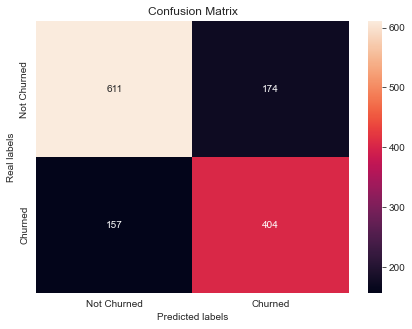

Score: 0.75
Accuracy:0.75
Precision:0.7
Recall:0.72
F1:0.71


In [444]:


y_pred = best_rf.predict(X_test[imp_features])
y_pred_prob = best_rf.predict_proba(X_test[imp_features])



produce_confusion('Churned', 'Un-Churned',y_test,y_pred)

print('Score:',round(best_rf.score(X_test[imp_features],y_test),2))
test_scores = apr(y_pred, y_test)


In [445]:

y_pred_proba = best_rf.predict_log_proba(X_test[feature_names])


In [446]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       785
           1       0.70      0.72      0.71       561

    accuracy                           0.75      1346
   macro avg       0.75      0.75      0.75      1346
weighted avg       0.76      0.75      0.75      1346



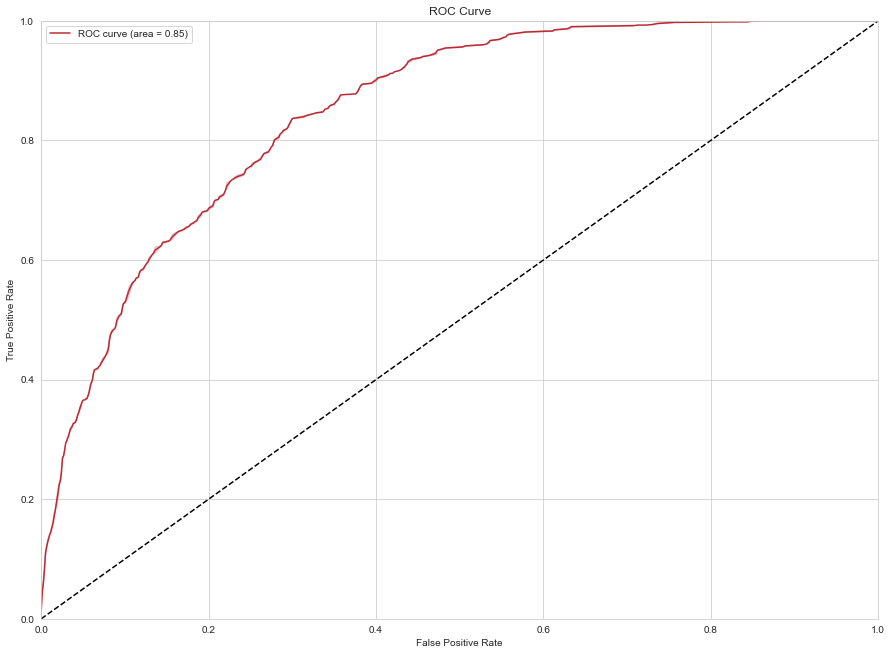

In [452]:
from sklearn.metrics import auc

# Calculate the false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label='1')

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Set figure size
plt.figure(figsize=(15, 11))

# Plot ROC curve
sns.lineplot(x=fpr,y=tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Find 500 customers most likely to churn

In [448]:
df_new['churn_probability'] = best_rf.predict_proba(df_new[imp_features]).T[0]
customers = df_new.sort_values(by='churn_probability', axis=0, ascending=False)
customers_500 = customers['CustomerID'].head(500)



In [449]:
customers_500.to_csv('customers_500.csv',index=False)

### Churn Risk of Remaining Customers

In [450]:
# find remaining customer id who are still un-churned
rem_customers = set(unchurned_df['CustomerID'])-set(customers_500)
# get a dataframe of remaining customers
rem_unchurned = X_unchurned[X_unchurned['CustomerID'].isin(rem_customers)]
rem_unchurned.shape

NameError: name 'X_unchurned' is not defined

In [ ]:
# finds the churn probability of remaining customers
y_rem_pred_prob = best_rf.predict_proba(rem_unchurned[imp_features]).T[0]
remain_cust = rem_unchurned[['CustomerID']].copy()
remain_cust['churn_probability'] = y_rem_pred_prob
remain_cust = remain_cust.sort_values('churn_probability',ascending=False)


In [ ]:
remain_cust.to_csv('churn_probabilities.csv',index=False)